<a href="https://colab.research.google.com/github/LK2705/sales-eda-project/blob/main/Random_Forest_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Load and prepare the data (same as before)
df = pd.read_csv('/content/Sales_April_2019.csv')

# Data cleaning
df = df.dropna()
df = df[df['Order ID'] != 'Order ID']

# Convert data types
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')
df = df.dropna()

# Create target variable
median_price = df['Price Each'].median()
df['High_Value'] = (df['Price Each'] > median_price).astype(int)

# Feature engineering
df['Hour'] = df['Order Date'].dt.hour
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Month'] = df['Order Date'].dt.month
df['City'] = df['Purchase Address'].str.split(',').str[1].str.strip()
df['Total_Value'] = df['Quantity Ordered'] * df['Price Each']

# Encode categorical variables
label_encoders = {}
categorical_features = ['Product', 'City']
for col in categorical_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features
numerical_features = ['Quantity Ordered', 'Hour', 'DayOfWeek', 'Month', 'Total_Value']
features = numerical_features + [col + '_encoded' for col in categorical_features]
X = df[features]
y = df['High_Value']

print(f"Dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Features: {features}")

Dataset shape: (18289, 7)
Class distribution:
High_Value
0    10222
1     8067
Name: count, dtype: int64
Features: ['Quantity Ordered', 'Hour', 'DayOfWeek', 'Month', 'Total_Value', 'Product_encoded', 'City_encoded']


In [2]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features (optional for tree-based models, but let's try both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 60)
print("MODEL TRAINING AND COMPARISON")
print("=" * 60)

MODEL TRAINING AND COMPARISON


In [5]:
# XGBoost Classifier
print("\n2. XGBOOST CLASSIFIER")
print("-" * 30)

# Basic XGBoost
xgb_basic = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best XGBoost model
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
y_pred_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]

print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Best CV Score: {xgb_grid.best_score_:.4f}")


2. XGBOOST CLASSIFIER
------------------------------
Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best CV Score: 1.0000


In [6]:
# Random Forest with hyperparameter tuning
print("\n1. RANDOM FOREST CLASSIFIER")
print("-" * 30)

# Basic Random Forest
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_basic.fit(X_train, y_train)
y_pred_rf_basic = rf_basic.predict(X_test)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best Random Forest model
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_pred_proba_rf = rf_best.predict_proba(X_test)[:, 1]

print(f"Best RF Parameters: {rf_grid.best_params_}")
print(f"RF Best CV Score: {rf_grid.best_score_:.4f}")


1. RANDOM FOREST CLASSIFIER
------------------------------
Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RF Best CV Score: 1.0000


In [7]:
# Comprehensive model comparison
print("\n3. MODEL COMPARISON")
print("-" * 30)

models = {
    'Random Forest Basic': (rf_basic, y_pred_rf_basic, y_pred_proba_rf),
    'Random Forest Tuned': (rf_best, y_pred_rf, y_pred_proba_rf),
    'XGBoost Basic': (xgb_basic, y_pred_xgb_basic, y_pred_proba_xgb),
    'XGBoost Tuned': (xgb_best, y_pred_xgb, y_pred_proba_xgb)
}

results = []
for name, (model, y_pred, y_pred_proba) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df.round(4))


3. MODEL COMPARISON
------------------------------

Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Random Forest Basic       1.0        1.0     1.0       1.0      1.0
1  Random Forest Tuned       1.0        1.0     1.0       1.0      1.0
2        XGBoost Basic       1.0        1.0     1.0       1.0      1.0
3        XGBoost Tuned       1.0        1.0     1.0       1.0      1.0


In [10]:
# Detailed classification reports
print("\n4. DETAILED CLASSIFICATION REPORTS")
print("=" * 50)

print("\nRandom Forest Tuned - Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nXGBoost Tuned - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Cross-validation scores
print("\n5. CROSS-VALIDATION RESULTS")
print("-" * 30)

cv_scores_rf = cross_val_score(rf_best, X, y, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(xgb_best, X, y, cv=5, scoring='accuracy')

print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
print(f"XGBoost CV Accuracy: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")


4. DETAILED CLASSIFICATION REPORTS

Random Forest Tuned - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3067
           1       1.00      1.00      1.00      2420

    accuracy                           1.00      5487
   macro avg       1.00      1.00      1.00      5487
weighted avg       1.00      1.00      1.00      5487


XGBoost Tuned - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3067
           1       1.00      1.00      1.00      2420

    accuracy                           1.00      5487
   macro avg       1.00      1.00      1.00      5487
weighted avg       1.00      1.00      1.00      5487


5. CROSS-VALIDATION RESULTS
------------------------------
Random Forest CV Accuracy: 1.0000 (+/- 0.0000)
XGBoost CV Accuracy: 1.0000 (+/- 0.0000)


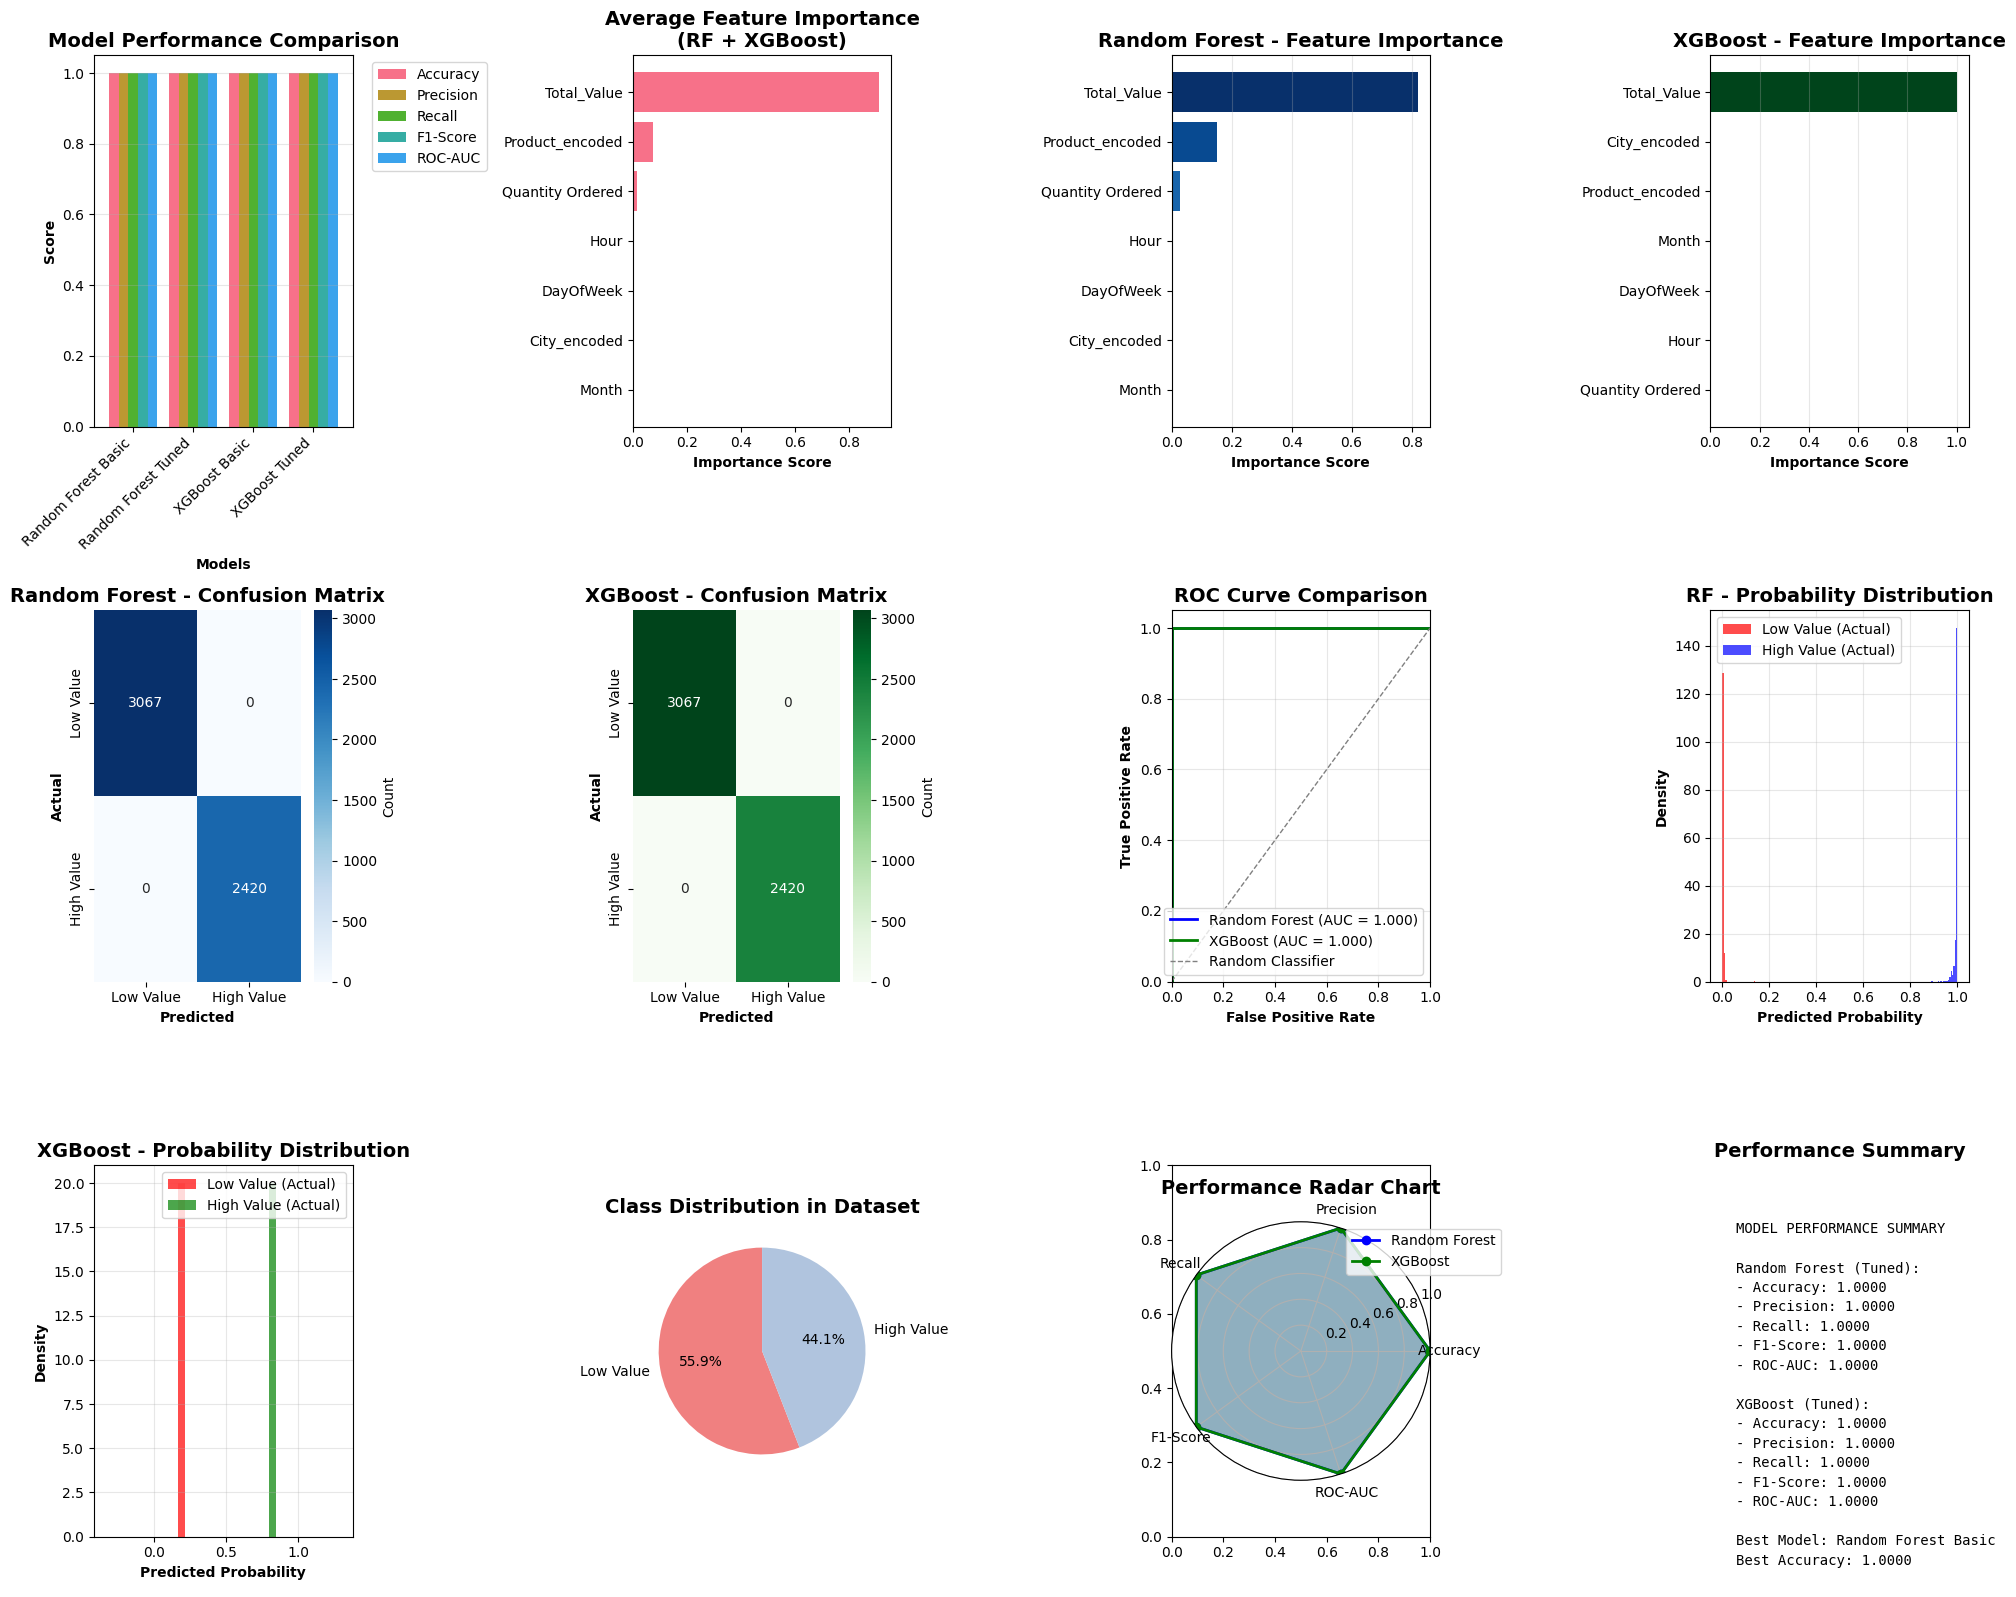

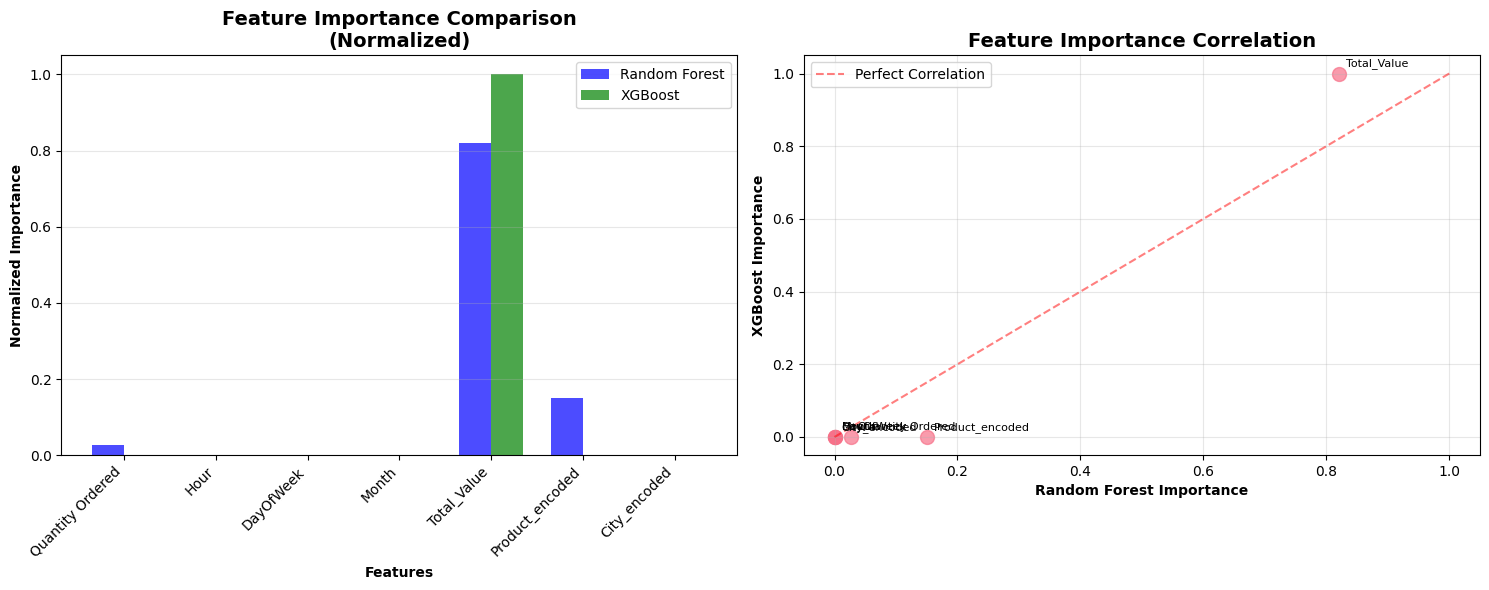

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Calculate best model based on accuracy
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model_accuracy = results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']

# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))

# 1. Model Performance Comparison Bar Chart
plt.subplot(3, 4, 1)
metrics_comparison = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_comparison.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)

# 2. Feature Importance Comparison - Horizontal Bar Chart
plt.subplot(3, 4, 2)
# Combine feature importances for comparison
feature_comp = pd.DataFrame({
    'Random Forest': rf_best.feature_importances_,
    'XGBoost': xgb_best.feature_importances_
}, index=features)
feature_comp = feature_comp.mean(axis=1).sort_values(ascending=True)

plt.barh(range(len(feature_comp)), feature_comp.values)
plt.yticks(range(len(feature_comp)), feature_comp.index)
plt.title('Average Feature Importance\n(RF + XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontweight='bold')
plt.tight_layout()

# 3. Individual Feature Importance - Random Forest
plt.subplot(3, 4, 3)
feature_importance_rf = pd.DataFrame({
    'feature': features,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=True)

colors_rf = plt.cm.Blues(np.linspace(0.4, 1, len(feature_importance_rf)))
plt.barh(feature_importance_rf['feature'], feature_importance_rf['importance'], color=colors_rf)
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# 4. Individual Feature Importance - XGBoost
plt.subplot(3, 4, 4)
feature_importance_xgb = pd.DataFrame({
    'feature': features,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=True)

colors_xgb = plt.cm.Greens(np.linspace(0.4, 1, len(feature_importance_xgb)))
plt.barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'], color=colors_xgb)
plt.title('XGBoost - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# 5. Confusion Matrix - Random Forest
plt.subplot(3, 4, 5)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Value', 'High Value'],
            yticklabels=['Low Value', 'High Value'],
            cbar_kws={'label': 'Count'})
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')

# 6. Confusion Matrix - XGBoost
plt.subplot(3, 4, 6)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low Value', 'High Value'],
            yticklabels=['Low Value', 'High Value'],
            cbar_kws={'label': 'Count'})
plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')

# 7. ROC Curve Comparison
plt.subplot(3, 4, 7)
# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# 8. Probability Distribution - Random Forest
plt.subplot(3, 4, 8)
plt.hist(y_pred_proba_rf[y_test == 0], bins=20, alpha=0.7, color='red', label='Low Value (Actual)', density=True)
plt.hist(y_pred_proba_rf[y_test == 1], bins=20, alpha=0.7, color='blue', label='High Value (Actual)', density=True)
plt.xlabel('Predicted Probability', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.title('RF - Probability Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 9. XGBoost Probability Distribution
plt.subplot(3, 4, 9)
plt.hist(y_pred_proba_xgb[y_test == 0], bins=20, alpha=0.7, color='red', label='Low Value (Actual)', density=True)
plt.hist(y_pred_proba_xgb[y_test == 1], bins=20, alpha=0.7, color='green', label='High Value (Actual)', density=True)
plt.xlabel('Predicted Probability', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.title('XGBoost - Probability Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 10. Class Distribution Pie Chart
plt.subplot(3, 4, 10)
class_distribution = y.value_counts()
plt.pie(class_distribution.values, labels=['Low Value', 'High Value'], autopct='%1.1f%%',
        colors=['lightcoral', 'lightsteelblue'], startangle=90)
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')

# 11. Performance Metrics Radar Chart
plt.subplot(3, 4, 11)
# Select metrics for radar chart
radar_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
radar_data_rf = results_df[results_df['Model'] == 'Random Forest Tuned'][radar_metrics].values[0]
radar_data_xgb = results_df[results_df['Model'] == 'XGBoost Tuned'][radar_metrics].values[0]

# Create radar chart
angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle
radar_data_rf = np.concatenate((radar_data_rf, [radar_data_rf[0]]))
radar_data_xgb = np.concatenate((radar_data_xgb, [radar_data_xgb[0]]))

ax = plt.subplot(3, 4, 11, polar=True)
ax.plot(angles, radar_data_rf, 'o-', linewidth=2, label='Random Forest', color='blue')
ax.fill(angles, radar_data_rf, alpha=0.25, color='blue')
ax.plot(angles, radar_data_xgb, 'o-', linewidth=2, label='XGBoost', color='green')
ax.fill(angles, radar_data_xgb, alpha=0.25, color='green')
ax.set_thetagrids(np.degrees(angles[:-1]), radar_metrics)
ax.set_ylim(0, 1)
plt.title('Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 12. Model Comparison Summary
plt.subplot(3, 4, 12)
plt.axis('off')

# Get performance metrics for summary
rf_tuned = results_df[results_df['Model'] == 'Random Forest Tuned'].iloc[0]
xgb_tuned = results_df[results_df['Model'] == 'XGBoost Tuned'].iloc[0]

summary_text = f"""
MODEL PERFORMANCE SUMMARY

Random Forest (Tuned):
- Accuracy: {rf_tuned['Accuracy']:.4f}
- Precision: {rf_tuned['Precision']:.4f}
- Recall: {rf_tuned['Recall']:.4f}
- F1-Score: {rf_tuned['F1-Score']:.4f}
- ROC-AUC: {rf_tuned['ROC-AUC']:.4f}

XGBoost (Tuned):
- Accuracy: {xgb_tuned['Accuracy']:.4f}
- Precision: {xgb_tuned['Precision']:.4f}
- Recall: {xgb_tuned['Recall']:.4f}
- F1-Score: {xgb_tuned['F1-Score']:.4f}
- ROC-AUC: {xgb_tuned['ROC-AUC']:.4f}

Best Model: {best_model_name}
Best Accuracy: {best_model_accuracy:.4f}
"""

plt.text(0.1, 0.9, summary_text, fontsize=10, fontfamily='monospace',
         verticalalignment='top', linespacing=1.5)
plt.title('Performance Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional: Feature Importance Comparison Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Feature importance side by side comparison
feature_importance_comp = pd.DataFrame({
    'Random Forest': rf_best.feature_importances_,
    'XGBoost': xgb_best.feature_importances_
}, index=features)

# Normalize for better comparison
feature_importance_comp = feature_importance_comp.div(feature_importance_comp.sum(axis=0), axis=1)

# Plot
x_pos = np.arange(len(features))
width = 0.35

ax1.bar(x_pos - width/2, feature_importance_comp['Random Forest'], width,
        label='Random Forest', color='blue', alpha=0.7)
ax1.bar(x_pos + width/2, feature_importance_comp['XGBoost'], width,
        label='XGBoost', color='green', alpha=0.7)

ax1.set_xlabel('Features', fontweight='bold')
ax1.set_ylabel('Normalized Importance', fontweight='bold')
ax1.set_title('Feature Importance Comparison\n(Normalized)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(features, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Correlation between feature importances
ax2.scatter(feature_importance_comp['Random Forest'],
           feature_importance_comp['XGBoost'],
           s=100, alpha=0.7)

# Add feature labels
for i, feature in enumerate(features):
    ax2.annotate(feature,
                (feature_importance_comp['Random Forest'].iloc[i],
                 feature_importance_comp['XGBoost'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Add correlation line
max_val = max(feature_importance_comp.max())
ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Correlation')
ax2.set_xlabel('Random Forest Importance', fontweight='bold')
ax2.set_ylabel('XGBoost Importance', fontweight='bold')
ax2.set_title('Feature Importance Correlation', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("=" * 70)